# Fine Tuning
## Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf

In [2]:
train_path = "C:/Users/aa641/Projects/Waste_Classification/data/TRAIN"  # Path of taining data
test_path = "C:/Users/aa641/Projects/Waste_Classification/data/TEST" # Path of testing data

In [3]:
from keras.models import Sequential, load_model ,Model
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.optimizers import SGD

## Importing the Dataset

In [4]:
BATCH_SIZE = 32 # Each batch will contain 32 images

# Creating Generator object
train_datagen = ImageDataGenerator(rescale= 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True) #configuring training images so that the model generalizes well

test_datagen = ImageDataGenerator(rescale= 1./255)

In [5]:
train_dataset = train_datagen.flow_from_directory(         # Importing training data directly from directory
        train_path,
        shuffle=True,
        target_size= (224,224),
        batch_size = BATCH_SIZE,
        color_mode= "rgb",
        class_mode= "binary")

validation_dataset = test_datagen.flow_from_directory(     # Importing validation data directly from directory
        test_path,
        shuffle=True,
        target_size= (224,224),
        batch_size = BATCH_SIZE,
        color_mode= "rgb",
        class_mode= "binary") 

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [6]:
nb_train_samples = len(train_dataset.filenames)           # Number of Training samples
num_classes = len(train_dataset.class_indices)            # Number of classes in Train dataset
nb_validate_samples = len(validation_dataset.filenames)   # Number of validation samples
num_classes_v = len(validation_dataset.class_indices)     # Number of classes in validation dataset
train_labels = train_dataset.classes                      # Labels for Train dataset
val_labels = validation_dataset.classes                   # Labels for validation dataset


print("nb_train_samples :",nb_train_samples) 
print("num_classes :",num_classes)
print("num_classes_v :",num_classes_v)
print("nb_validation_samples :",nb_validate_samples)
print("train_labels :",train_labels)
print("val_labels :",val_labels)

nb_train_samples : 22564
num_classes : 2
num_classes_v : 2
nb_validation_samples : 2513
train_labels : [0 0 0 ... 1 1 1]
val_labels : [0 0 0 ... 1 1 1]


## Importing the Model

In [7]:
import joblib

# loading the saved model
model = joblib.load(open("C:/Users/aa641/Projects/Waste_Classification/model/wc_vgg19_model_n.pkl", "rb"))

## Fune Tuning

In [8]:
# Set up fine tuning on pre-trained ImageNet vgg19 model
# to train all layers for VGG19 models
model.trainable = True

    
for layer in model.layers[:-3]: 
    layer.trainable = False

In [9]:
# Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(learning_rate = 0.0001, momentum=0.9), 
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

In [10]:
# A callback  
earlystop = tf.keras.callbacks.EarlyStopping(
                           monitor='val_loss',       # which monitors the Validation loss
                           min_delta=0,              # and stops the training if the loss doesnt improve
                           patience=3,               # for 3 consecutive turns 
                           verbose=1,
                           restore_best_weights=True # and restores best weights
                           )

In [11]:
# Fit the revised model, log the results

callbacks = [earlystop]
epochs = 10
batch_size = 32

fine_tuning_history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    steps_per_epoch = 150,
    validation_steps = 50,
    epochs = epochs,
    callbacks=callbacks)

Epoch 1/10


150/150 [==============================] - 783s 5s/step - loss: 0.3514 - accuracy: 0.8585 - val_loss: 0.3598 - val_accuracy: 0.8656
Epoch 2/10
150/150 [==============================] - 833s 6s/step - loss: 0.3562 - accuracy: 0.8523 - val_loss: 0.3499 - val_accuracy: 0.8719
Epoch 3/10
150/150 [==============================] - 837s 6s/step - loss: 0.3523 - accuracy: 0.8588 - val_loss: 0.3383 - val_accuracy: 0.8850
Epoch 4/10
150/150 [==============================] - 834s 6s/step - loss: 0.3441 - accuracy: 0.8590 - val_loss: 0.3394 - val_accuracy: 0.8806
Epoch 4: early stopping


## Model Evaluation

In [12]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validation_dataset, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3434123396873474
Test Accuracy: 0.8750497698783875


In [42]:
# list all data in history
print(fine_tuning_history.history.keys())
acc = fine_tuning_history.history['accuracy']
val_acc = fine_tuning_history.history['val_accuracy']

loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


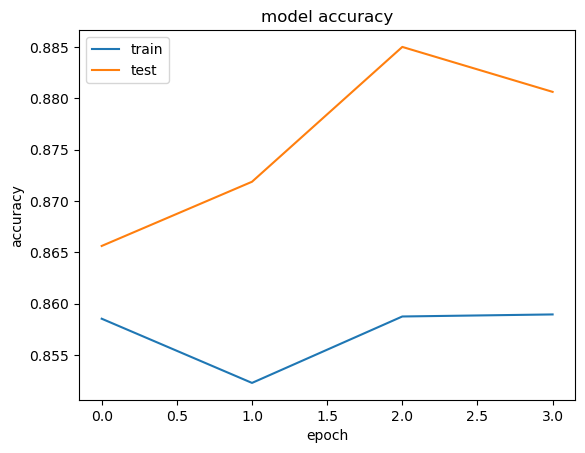

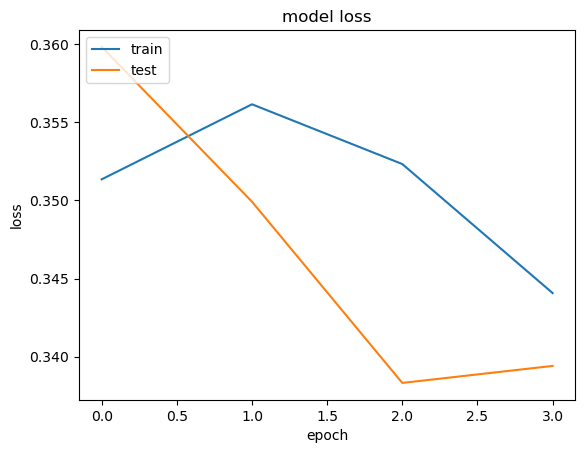

In [13]:
# summarize history for accuracy
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

## Custom predictions

In [16]:
# A custorm prediction function that 
def predict_func(img):
    plt.figure(figsize=(6,4))                          # plots the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))   # as a coloured figure
    img = cv2.resize(img, (224, 224))                  
    img = np.reshape(img, [-1, 224, 224,3])            # resizes it to fit the input layer of our classifier model
    result = model.predict(img)                        # and predicts using the model
    
    if result > 0.5:
        print("The waste in image is -> Recyclable")
    else:
        print("The waste in image is -> Organic")

1/1 [==============================] - 0s 213ms/step
The waste in image is -> Recyclable
1/1 [==============================] - 0s 221ms/step
[[1.]]


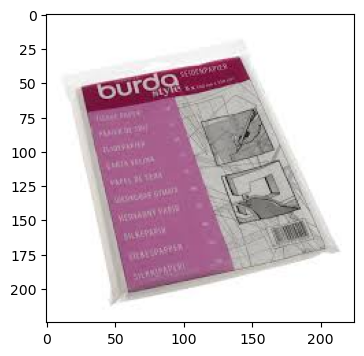

In [17]:
test_img = cv2.imread("C:/Users/aa641/Projects/Waste_Classification/data/TEST/R/R_10857.jpg")
predict_func(test_img)

1/1 [==============================] - 1s 550ms/step
The waste in image is -> Organic
1/1 [==============================] - 0s 159ms/step
[[0.00389321]]


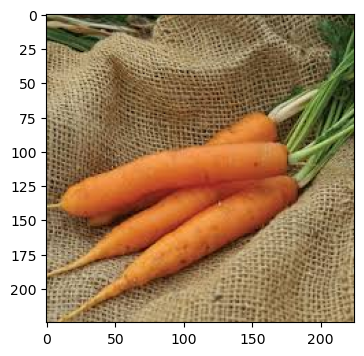

In [36]:
test_img = cv2.imread("C:/Users/aa641/Projects/Waste_Classification/data/TEST/O/O_12628.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 141ms/step
The waste in image is -> Organic
1/1 [==============================] - 0s 129ms/step
[[7.056382e-25]]


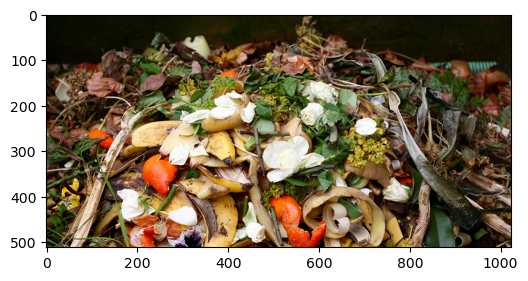

In [38]:
test_img = cv2.imread("C:/Users/aa641/Projects/Waste_Classification/data/TEST/O/O_new.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 164ms/step
The waste in image is -> Recyclable
1/1 [==============================] - 0s 115ms/step
[[0.9996869]]


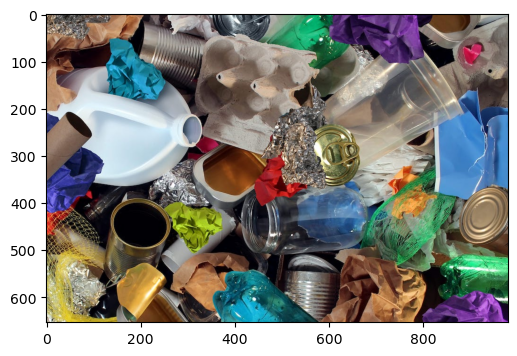

In [39]:
test_img = cv2.imread("C:/Users/aa641/Projects/Waste_Classification/data/TEST/R/R_new.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 144ms/step
The waste in image is -> Recyclable
1/1 [==============================] - 0s 120ms/step
[[0.9854818]]


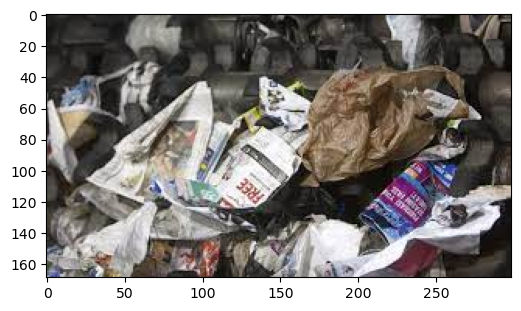

In [40]:
test_img = cv2.imread("C:/Users/aa641/Projects/Waste_Classification/data/TEST/R/R_new_1.jpg")
predict_func(test_img)

### Saving the model

In [24]:
# save fine-tuning model for offline prediction purposes
import os
import joblib

if not os.path.exists("C:/Users/aa641/Projects/Waste_Classification/model"):
    os.mkdir("C:/Users/aa641/Projects/Waste_Classification/model")
joblib.dump(model,"C:/Users/aa641/Projects/Waste_Classification/model/wc_vgg19_model_tl.pkl")
print("Successfully Completed !")

Successfully Completed !
